<a href="https://colab.research.google.com/github/leolani/cltl-face-all/blob/master/examples/colab/4.ERC-MELD-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will train our simples models here together.

We'll start with the small pre-defined dataset.

## Clone the repo, download the necessary files, etc.

In [ ]:
%cd /content
!git clone https://github.com/leolani/cltl-face-all
!cd cltl-face-all/ && pip install .
!pip install omegaconf==2.0.5
!pip install tqdm av

# Download the annotations and stuff
!wget https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datasets-jsons/dataset-small.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datasets-jsons/dataset-medium.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datasets-jsons/dataset-large.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datasets-jsons/datasets.json

!gdown --id 1rsLbfgQYztDtrPFqEmkh-2d_0ap1qd_s
!unzip visual-features-smaller-dataset.zip
!rm visual-features-smaller-dataset.zip

!gdown --id 16ck7plW9v9eSHGCs5wuB2AhhufPRt3Wi
!unzip smaller-dataset.zip
!rm smaller-dataset.zip

!ls smaller-dataset/  |  wc -l
!ls visual-features-smaller-dataset | wc -l

In [2]:
import json

with open('datasets.json', 'r') as stream:
    datasets = json.load(stream)

datasets = datasets['large']

## Randomly select a video and play it



In [6]:
from glob import glob
import random
import os
import json
import numpy as np
import av
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import HTML
from base64 import b64encode

VISUAL_FEATURES_PATH = 'visual-features-smaller-dataset/'
VIDEOS_PATH = "smaller-dataset/"

diautt = random.choice([foo for foo, bar in datasets['train'].items()])
annot = datasets['train'][diautt]
features_path = os.path.join(VISUAL_FEATURES_PATH, diautt) + '.npy'

features = np.load(features_path, allow_pickle=True)
# below line is necessary since the saved file is actually a dictionary.
features = features.item()

vid_path = os.path.join(VIDEOS_PATH, diautt) +  '.mp4'
container = av.open(vid_path)

print(vid_path)
print(annot)

frames = {}
for idx, frame in enumerate(container.decode(video=0)):
    numpy_RGB = np.array(frame.to_image())
    frames[idx] = numpy_RGB

assert np.abs(len(frames) - len(features)) <= 1

mp4 = open(vid_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=1280 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

smaller-dataset/dia576_utt5.mp4
{'SrNo': '5725', 'Utterance': 'Heads.', 'Speaker': 'Joey', 'Emotion': 'neutral', 'Sentiment': 'neutral', 'Dialogue_ID': '576', 'Utterance_ID': '5', 'Season': '2', 'Episode': '6', 'StartTime': '00:16:06,507', 'EndTime': '00:16:07,840'}


## Randomly select a frame and check it

10


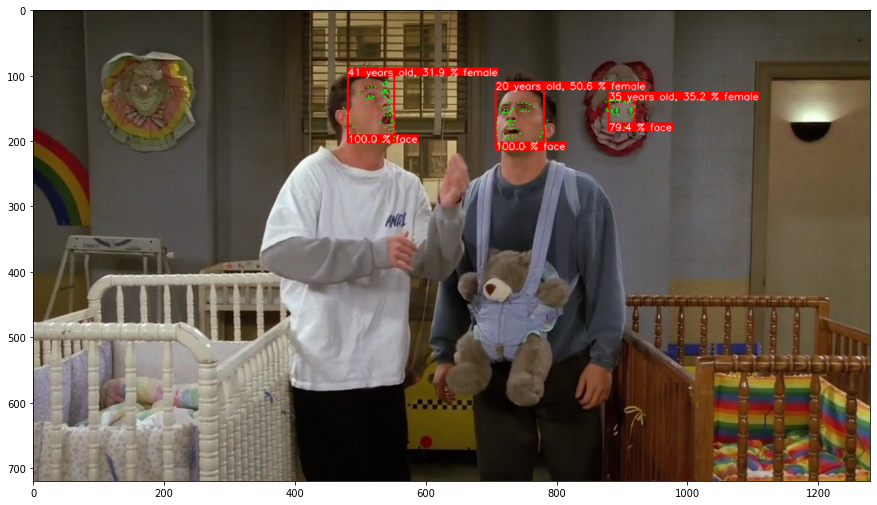

SrNo 	 5725
Utterance 	 Heads.
Speaker 	 Joey
Emotion 	 neutral
Sentiment 	 neutral
Dialogue_ID 	 576
Utterance_ID 	 5
Season 	 2
Episode 	 6
StartTime 	 00:16:06,507
EndTime 	 00:16:07,840


In [7]:
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.8, thickness=1):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)
    
idx = random.choice(list(frames.keys()))
img = frames[idx]
print(idx)

feature = features[idx]

for feat in feature:
    bbox = feat['bbox']
    landmark = feat['landmark']
    age = feat['age']
    gender = feat['gender']
    embedding = feat['embedding']
    # face = feat['face']

    x1, y1, x2, y2, prob = bbox
    
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    label = f"{str(round(prob*100, 1))} % face"
    draw_label(img, (x1, y2), label, font_scale=0.5, thickness=1)

    for lm in landmark:
        cv2.circle(img, (int(lm[0]), int(lm[1])), 1, (0,255,0), -1)

    label = f"{int(age)} years old, {str(round(gender*100, 1))} % female"
    draw_label(img, (x1, y1), label, font_scale=0.5, thickness=1)
    
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

for key, val in annot.items():
    print(key, '\t', val)

## The datasets structure

It comes with three different sizes.

In [8]:
datasets.keys()

dict_keys(['train', 'dev', 'test'])

In [9]:
for key, val in datasets.items():
    print(key, len(val))

train 584
dev 97
test 108


## Let's see how the data actually looks like

run the below cell.

In [10]:
datasets['train']['dia1000_utt0']

{'Dialogue_ID': '1000',
 'Emotion': 'disgust',
 'EndTime': '00:06:49,783',
 'Episode': '3',
 'Season': '2',
 'Sentiment': 'negative',
 'Speaker': 'Monica',
 'SrNo': '10029',
 'StartTime': '00:06:45,780',
 'Utterance': 'Would you look at this dump? He hated us. This is his final revenge!',
 'Utterance_ID': '0'}

## Let's check out the data distributions.

In [11]:
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter

def count2ratio(counts):
    total_counts = sum([val for key, val in counts.items()])

    return {key: round(val/total_counts, 3) for key, val in counts.items()}

for key, val in datasets.items():
    sentiments = []
    emotions = []
    speakers = []

    for diautt, annot in val.items():
        sentiments.append(annot['Sentiment'])
        emotions.append(annot['Emotion'])
        speakers.append(annot['Speaker'])

    sentiments = dict(Counter(sentiments))
    emotions = dict(Counter(emotions))
    speakers = dict(Counter(speakers))

    sentiments = count2ratio(sentiments)
    emotions = count2ratio(emotions)
    speakers = count2ratio(speakers)

    print(key, 'sentiments', sentiments)
    print(key, 'emotions', emotions)
    print(key, 'speakers', sentiments)
    print()

train sentiments {'negative': 0.274, 'neutral': 0.473, 'positive': 0.253}
train emotions {'disgust': 0.026, 'anger': 0.091, 'neutral': 0.473, 'sadness': 0.082, 'joy': 0.182, 'surprise': 0.125, 'fear': 0.022}
train speakers {'negative': 0.274, 'neutral': 0.473, 'positive': 0.253}

dev sentiments {'positive': 0.206, 'neutral': 0.557, 'negative': 0.237}
dev emotions {'surprise': 0.072, 'neutral': 0.557, 'joy': 0.175, 'disgust': 0.052, 'anger': 0.072, 'fear': 0.021, 'sadness': 0.052}
dev speakers {'positive': 0.206, 'neutral': 0.557, 'negative': 0.237}

test sentiments {'negative': 0.259, 'neutral': 0.509, 'positive': 0.231}
test emotions {'surprise': 0.167, 'neutral': 0.509, 'anger': 0.056, 'sadness': 0.12, 'joy': 0.13, 'fear': 0.009, 'disgust': 0.009}
test speakers {'negative': 0.259, 'neutral': 0.509, 'positive': 0.231}



# **TODO0**: 
Down-sample the data. 

In [12]:
import pandas as pd

BALANCE = True

def balance(train):
  """
  Balances the classes by down-sampling.
  """
  df = pd.DataFrame(train).T
  g = df.groupby('Emotion', group_keys=False)
  train = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)
  return train

if BALANCE:
  datasets['balanced_train'] = balance(datasets['train'])

When it comes to the emotion classes, you can see that the label `neutral` accounts for nearly half of the instances. **This means that if your emotion classifier performs less than the accuracy of 50%, you are doing something wrong.**



## TODO1:

Extract viasual features or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Tae and Wes.

In [13]:
import os
from glob import glob
import numpy as np
from cltl_face_all.arcface import calc_angle_distance
from tqdm.notebook import tqdm


predefined_faces_= glob(os.path.join('./cltl-face-all/your-faces/*/*.npy'))
predefined_faces = {}

for path in predefined_faces_:
    name = path.split('/')[-2]
    predefined_faces[name] = np.load(path)

vecs = {}
THRESHOLDS = {'face': 0.9, 'angle': 1.15}

for DATASET in tqdm(['train', 'dev', 'test']):
    vecs[DATASET] = {}
    for diautt, annot in datasets[DATASET].items():
        vecs[DATASET][diautt] = {}
        speaker = annot['Speaker']

        visual_features = np.load(f'visual-features-smaller-dataset/{diautt}.npy', \
                                    allow_pickle=True).item()

        for frame, features in visual_features.items():
            vecs[DATASET][diautt][frame] = None
            # Assume that there is only one unique face per frame.
            for feat in features:
                age = feat['age']
                gender = feat['gender']
                bbox = feat['bbox']
                embedding = feat['embedding']
                landmark = feat['landmark']

                if bbox[-1] < THRESHOLDS['face']:
                    continue

                if speaker not in list(predefined_faces.keys()):
                    continue

                embedding.reshape(1, 512)

                dists = {key: calc_angle_distance(embedding, val) for key, val \
                            in predefined_faces.items()}

                if dists[speaker] < THRESHOLDS['angle']:
                    vecs[DATASET][diautt][frame] = landmark


In [14]:
vecs_with_speaker = {}

for DATASET in tqdm(['train', 'dev', 'test']):
    vecs_with_speaker[DATASET] = {}

    print(f"{len(vecs[DATASET])} videos in {DATASET}")
    for diautt, frame_landmarks in vecs[DATASET].items():
        with_speaker = [lm for lm in frame_landmarks.values() if lm is not None]
        if len(with_speaker) > 0:
            vecs_with_speaker[DATASET][diautt] = with_speaker

    print(f"{len(vecs_with_speaker[DATASET])} videos in {DATASET}, after removing the utterances without the speaker face")
    print(f"the ratio is {len(vecs_with_speaker[DATASET]) / len(vecs[DATASET])}")
    print()

584 videos in train
517 videos in train, after removing the utterances without the speaker face
the ratio is 0.8852739726027398

97 videos in dev
81 videos in dev, after removing the utterances without the speaker face
the ratio is 0.8350515463917526

108 videos in test
94 videos in test, after removing the utterances without the speaker face
the ratio is 0.8703703703703703




In [19]:
X = {}
y = {}

original_diautt = {}

emotion2num = {'anger': 0,
               'disgust': 1,
               'fear': 2,
               'joy': 3,
               'neutral': 4,
               'sadness': 5, 
               'surprise': 6}
num2onehot = {0: np.array([1, 0, 0, 0, 0, 0, 0]),
              1: np.array([0, 1, 0, 0, 0, 0, 0]),
              2: np.array([0, 0, 1, 0, 0, 0, 0]),
              3: np.array([0, 0, 0, 1, 0, 0, 0]),
              4: np.array([0, 0, 0, 0, 1, 0, 0]),
              5: np.array([0, 0, 0, 0, 0, 1, 0]),
              6: np.array([0, 0, 0, 0, 0, 0, 1])}

for DATATYPE in ['train', 'dev', 'test']:
    X[DATATYPE] = []
    y[DATATYPE] = []
    original_diautt[DATATYPE] = []
    for diautt, landmarks in vecs_with_speaker[DATATYPE].items():
        label = datasets[DATATYPE][diautt]['Emotion']
        X[DATATYPE].append(landmarks)
        y[DATATYPE].append(num2onehot[emotion2num[label]])
        original_diautt[DATATYPE].append(diautt)


In [20]:
import pickle

with open('compact-visual.pkl', 'wb') as stream:
    pickle.dump({'X': X, 'y': y, 'original_diautt': original_diautt}, stream)

In [21]:
len(X['train']), len(X['train'][0]), X['train'][0][0].shape, y['train'][0], len(original_diautt['train'])

(517, 9, (68, 2), array([0, 1, 0, 0, 0, 0, 0]), 517)

## TODO2:

Extract text features  or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Nihat and Zeynep.

## Roberta Text Classification

In [ ]:
!pip install transformers==3.0.2

     |████████████████████████████████| 778kB 3.9MB/s 
     |████████████████████████████████| 1.1MB 17.8MB/s 
     |████████████████████████████████| 890kB 26.8MB/s 
     |████████████████████████████████| 3.0MB 18.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f4fbeb6e3e16f24d9fda92e99a5aada1358841755884f27f378147899d81cd92
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# Transformers packages
import transformers
from transformers import RobertaModel, RobertaTokenizer
# Torch packages
import torch
from torch.utils.data import Dataset, DataLoader
from torch import cuda

# Check for the device
device = 'cuda' if cuda.is_available() else 'cpu'

### Embedding

In [ ]:
import pandas as pd
import numpy as np
import requests
import io

# Download data
download_train = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv').content
download_val = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/dev_sent_emo.csv').content
download_test = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/test_sent_emo.csv').content

# Create frames
df_train = pd.read_csv(io.StringIO(download_train.decode('utf-8')))
df_val = pd.read_csv(io.StringIO(download_val.decode('utf-8')))
df_test = pd.read_csv(io.StringIO(download_test.decode('utf-8')))

# Decrease the number of neutral instance
# 9989 -> 8279
df_train_neutral = df_train[df_train.Emotion == 'neutral']
df_train_neutral = df_train_neutral.sample(n=len(df_train_neutral)-2000)
# df_train_neutral.head()
df_train_neutral_ind = df_train_neutral.index
df_train = df_train.drop(index=df_train_neutral_ind).reset_index()
df_train.Emotion.value_counts()

class_names = [
    'neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear'
]

def transform_labels(emotion):
    if emotion == 'neutral': return 0
    elif emotion == 'joy': return 1
    elif emotion == 'surprise': return 2
    elif emotion == 'anger': return 3
    elif emotion == 'sadness': return 4
    elif emotion == 'disgust': return 5
    elif emotion == 'fear': return 6

df_train['enc_emotion'] = df_train.Emotion.apply(transform_labels)
df_val['enc_emotion'] = df_val.Emotion.apply(transform_labels)
df_test['enc_emotion'] = df_test.Emotion.apply(transform_labels)

# Defining some key variables that will be used later on in the training
MAX_LEN = 256
BATCH_SIZE = 16
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
# MODEL_NAME = "roberta-large"
MODEL_NAME = "roberta-base"
LEARNING_RATE = 2e-05
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, truncation=True, do_lower_case=True)

Hi everyone! 
I added a graph below to show the token distribution over the training dataset. I would recommend setting MAX_LENGTH to whatever comes out of this graph. It may save some time reading in the files. 512 is a lot of tokens contained in a spoken sentence...

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

token_lens = []

for txt in df_train.Utterance:
  tokens = tokenizer.encode(txt, truncation=True,max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

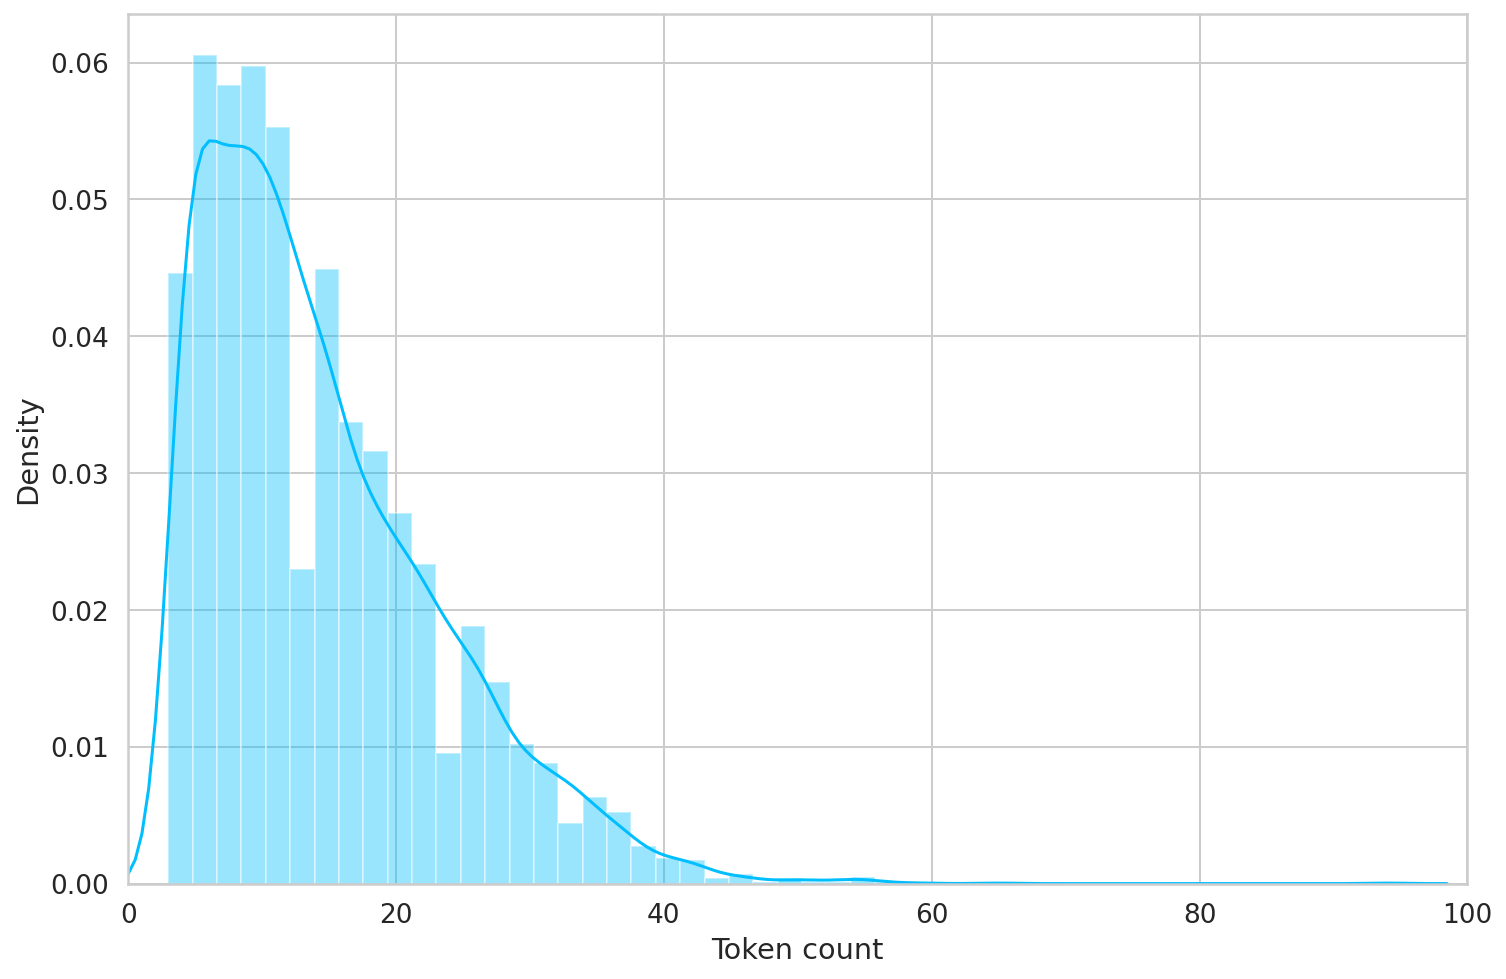

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count')

In [ ]:
def utterance_encode(utterance: str):
    inputs = tokenizer.encode_plus(
        utterance,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_token_type_ids=True
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]

    return {
        'ids': torch.tensor(ids, dtype=torch.long).unsqueeze(0),
        'mask': torch.tensor(mask, dtype=torch.long).unsqueeze(0),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
    }

### Model

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained('roberta-base')
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        # print(pooler.size())
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = RobertaClass().to(device=device)

In [ ]:
file_id = '1--TzzCipxlgo17bWNhY0Z4rWNQWzFpMv'
!gdown https://drive.google.com/uc?id={file_id}

# Load configs to the existing model
model.load_state_dict(torch.load('pytorch_roberta_sentiment.bin'))

Downloading...
From: https://drive.google.com/uc?id=1--TzzCipxlgo17bWNhY0Z4rWNQWzFpMv
To: /content/pytorch_roberta_sentiment.bin
501MB [00:05, 84.2MB/s]


NameError: ignored

In [ ]:
def predict_emotion(utterance) -> tuple:
    '''
    utterance: str
        The utterance text.
    
    Returns tuple.
        First item is the belonging class name.
        Second item is the encoded class name.
    '''
    # Encode inputs
    inputs = utterance_encode(utterance)
    # Parse into needed variables
    ids = inputs['ids'].to(device, dtype = torch.long)
    mask = inputs['mask'].to(device, dtype = torch.long)
    token_type_ids = inputs['token_type_ids'].to(device, dtype = torch.long)

    # Predict
    output = model(ids, mask, token_type_ids)
    _, prediction = torch.max(output, dim=1)

    return (class_names[prediction], prediction.item())

cls_name, pred = predict_emotion("why you did that??")

## TODO3:

Extract audio features  or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Vivian.

In [ ]:
! pip install librosa

In [ ]:
from tqdm import tqdm
import librosa 
import numpy as np
import pandas as pd
from numpy import std

NORMALISE = True

def get_features(df):
  data = pd.DataFrame(columns=['feature'])
  label = pd.DataFrame(columns=['label'])
  
  print(f'Number of rows in DataFrame: {len(df)}')

  for row in tqdm(df.itertuples()):
    try:
      path = f'./smaller-dataset/{row.Index}.mp4'
      y, sr = librosa.load(path, sr=None)

      result = np.array([])

      ## MFCCs
      mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
      result = np.hstack((result, mfccs))

      ## Chroma
      stft= np.abs(librosa.stft(y))
      chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
      result = np.hstack((result, chroma))

      ## Mel Scale
      mel = np.mean(librosa.feature.melspectrogram(y , sr=sr).T, axis=0)
      result = np.hstack((result, mel))

      label.loc[row.Index, 'label'] = df.loc[row.Index, 'Emotion']
      data.loc[row.Index] = [result]

    except:
      print(f'failed for {row.Index}')

  final_data = pd.DataFrame(data['feature'].values.tolist(), index=data.index)
  final_data = pd.concat([final_data, label], axis=1)

  print(final_data)

  return final_data

In [ ]:
for x, dataset in datasets.items():
  df = pd.DataFrame(dataset).T
  #if x == 'train':
  #  audio_train = get_features(df)
  #if x == 'balanced':
  #  audio_balanced_train = get_features(df)

  #if x == 'dev':
  #  audio_dev = get_features(df)

  if x == 'test':
    audio_test = get_features(df)

0it [00:00, ?it/s]

Number of rows in DataFrame: 108


108it [00:37,  2.90it/s]

                       0           1  ...           179     label
dia919_utt0  -399.208023  170.104446  ...  3.478638e-10  surprise
dia919_utt1  -513.692560  120.817963  ...  3.434812e-10   neutral
dia939_utt0  -309.260906  212.982965  ...  2.516845e-09     anger
dia939_utt1  -401.527491  213.140379  ...  8.332283e-09   neutral
dia939_utt10 -417.272631  149.906462  ...  3.737968e-10   neutral
...                  ...         ...  ...           ...       ...
dia990_utt9  -529.120634  139.012954  ...  3.480766e-10   neutral
dia993_utt0  -422.277357  194.421446  ...  7.307671e-10       joy
dia993_utt1  -520.314900  171.830605  ...  3.440212e-10       joy
dia993_utt2  -504.501156  146.317197  ...  3.591791e-10   neutral
dia993_utt3  -407.913710  176.432056  ...  6.234988e-09   neutral

[108 rows x 181 columns]


In [ ]:
audio_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,1.080000e+02,108.000000,108.000000,1.080000e+02,1.080000e+02,108.000000,1.080000e+02,108.000000,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
mean,-449.002734,161.399592,-43.185369,34.484313,-1.884175,0.510149,-0.306777,-6.212422,-0.587288,-11.429564,-1.764804,-2.783998,-3.804907,-2.468010,-2.907230,-5.270376,-1.824390,-0.047083,-2.868993,-1.604235,-3.636393,-1.355871,-0.643646,-2.096974,-2.598024,-1.326823,-2.082401,-2.235044,0.390536,-1.487642,-1.012101,-0.923269,-1.233596,-1.836406,-1.603315,-1.612682,-2.442069,-0.396964,-0.923406,-0.507123,...,8.977708e-04,0.000891,0.000811,8.911093e-04,8.931428e-04,0.000585,5.469693e-04,0.000473,3.847711e-04,2.768649e-04,1.907911e-04,1.152752e-04,9.050601e-05,6.505787e-05,4.787886e-05,2.907833e-05,2.211959e-05,1.390324e-05,1.065263e-05,6.826902e-06,4.829944e-06,3.232336e-06,2.426096e-06,1.356809e-06,5.632964e-07,5.734071e-08,5.133029e-08,5.147364e-08,3.809979e-08,2.450279e-08,1.908461e-08,1.312771e-08,9.653161e-09,8.483491e-09,7.685351e-09,7.090411e-09,6.637467e-09,6.304656e-09,6.073962e-09,5.947591e-09
std,64.931596,25.084961,17.611047,15.148387,12.117786,8.445393,9.020228,4.997055,5.745894,5.634162,5.742071,4.614130,4.964153,5.616467,3.544337,4.443462,3.424399,3.420695,3.887761,3.581464,3.650437,3.143375,2.887121,2.949389,2.960863,2.922353,3.132896,3.534782,2.857661,2.925722,3.305574,2.486757,2.713954,2.426042,2.060135,2.482876,2.468619,2.203462,2.339450,2.160990,...,1.458204e-03,0.001534,0.001436,1.956611e-03,2.936605e-03,0.000947,8.859763e-04,0.000832,8.187749e-04,5.846747e-04,3.672020e-04,1.983095e-04,1.467965e-04,1.242313e-04,8.640390e-05,4.779446e-05,4.209860e-05,2.117561e-05,1.541204e-05,9.822281e-06,6.940867e-06,5.225126e-06,4.346936e-06,2.023492e-06,7.949405e-07,1.149800e-07,1.162827e-07,1.323432e-07,1.162814e-07,8.380668e-08,6.940416e-08,4.731395e-08,3.911711e-08,3.467054e-08,3.127873e-08,2.872483e-08,2.672636e-08,2.525021e-08,2.423591e-08,2.369826e-08
min,-617.022622,81.401836,-84.685402,6.636059,-29.923486,-21.617192,-15.763605,-18.181878,-15.213731,-32.620381,-13.390753,-15.282442,-16.380683,-14.488434,-10.598779,-16.011844,-10.031589,-7.608302,-12.270164,-10.500324,-11.288882,-7.425345,-6.435995,-9.404783,-10.803344,-6.287670,-8.358915,-9.942114,-7.199767,-6.367309,-7.895169,-6.068198,-6.421773,-6.453283,-6.053739,-7.508262,-7.382752,-4.966716,-6.531594,-6.237845,...,8.103376e-07,0.000001,0.000001,9.379995e-07,9.719064e-07,0.000001,9.143854e-07,0.000001,9.948443e-07,5.333915e-07,5.231736e-07,3.915756e-07,3.646204e-07,2.933253e-07,3.080757e-07,2.272801e-07,1.869909e-07,1.619171e-07,1.433821e-07,1.073768e-07,7.333008e-08,6.195550e-08,5.019015e-08,4.150083e-08,2.303972e-08,4.209498e-10,3.621840e-10,3.694557e-10,3.522349e-10,3.425168e-10,3.445349e-10,3.464972e-10,3.475126e-10,3.342508e-10,3.389953e-10,3.325790e-10,3.342821e-10,3.131417e-10,3.099725e-10,3.302431e-10
25%,-497.784955,147.801828,-54.687513,2

# TODO5:

1Set up baseline.


## TOOD4:

Concatenate the three feature vectors and/or train a simple classifier. Start simple (e.g. one-layered logistic regression). This should be done all together.

I (Viv) would propose the following structure for the voting system.


1.   **Scenario 1**: Each modality outputs the same emotion --> pick this emotion.
2.   **Scenario 2**: Two modalities output the same emotion --> pick this emotion.
3.   **Scenario 3**: Each modality outputs a different emotion. Depending on which of the three initial base models performs best (likely video or text?), select this option.



In [ ]:
#DO IT